In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

Reading the dataset

In [79]:
df = pd.read_csv('datasets\Wednesday-workingHours.pcap_ISCX.csv')
df.columns = df.columns.str.strip()
df.shape

(692703, 79)

In [97]:
print(df.columns.tolist())


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

Target Distribution

In [80]:
label_counts = df['Label'].value_counts()
label_counts

Label
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

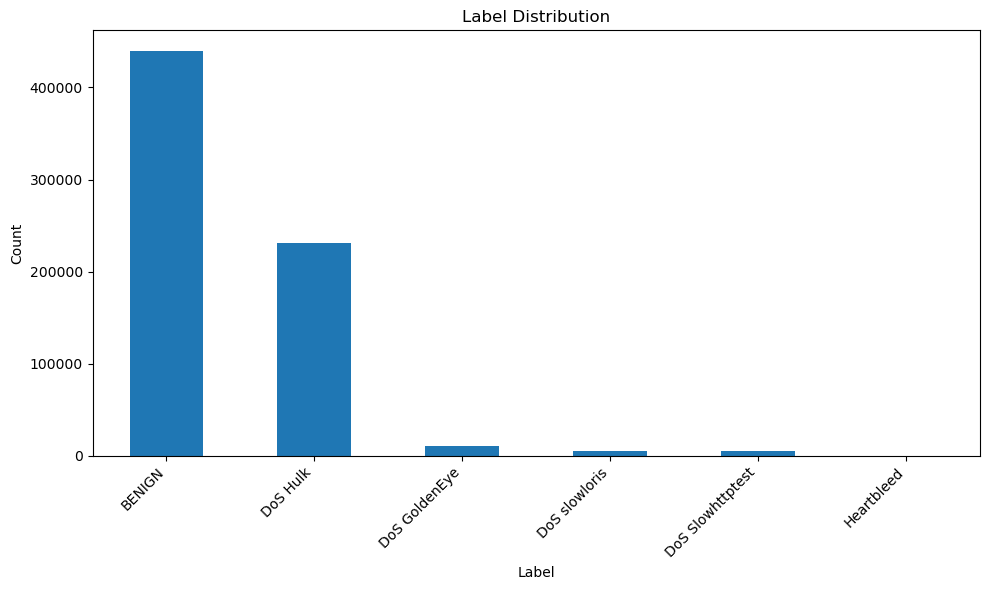

In [81]:
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')

plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

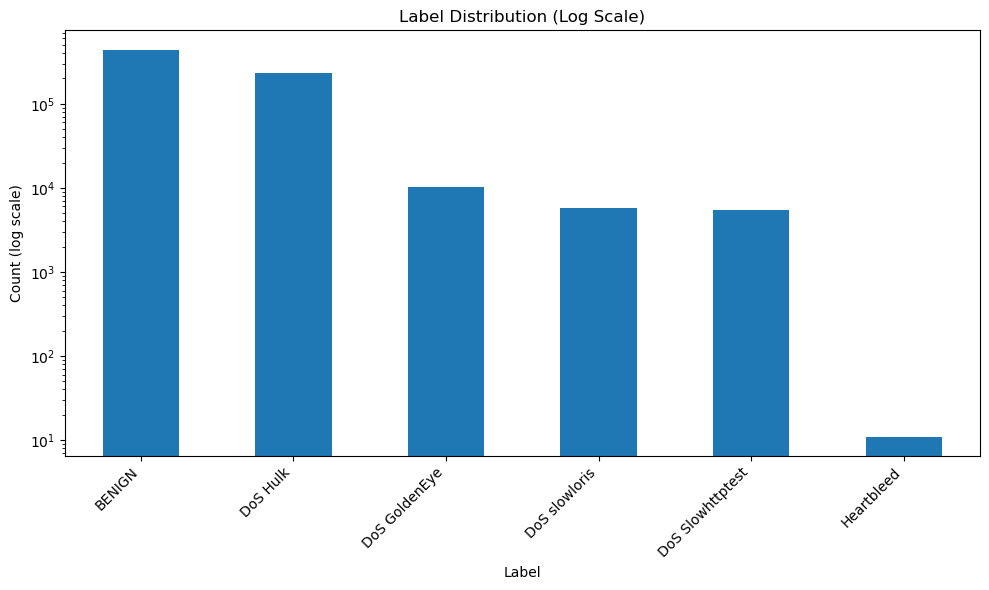

In [82]:
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')

plt.yscale('log')
plt.title("Label Distribution (Log Scale)")
plt.xlabel("Label")
plt.ylabel("Count (log scale)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


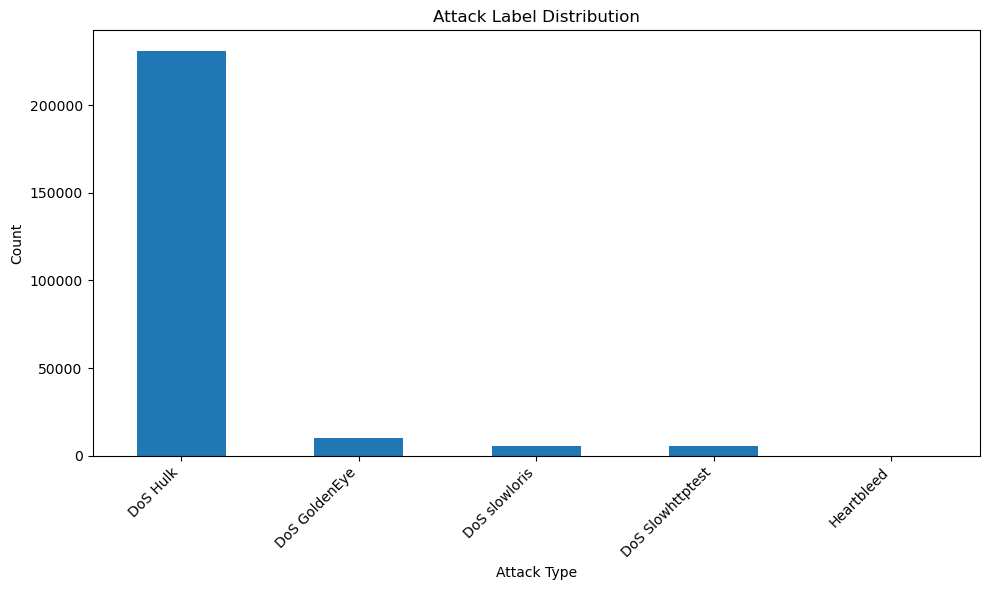

In [83]:
plt.figure(figsize=(10, 6))
label_counts.drop('BENIGN').plot(kind='bar')

plt.title("Attack Label Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


PreProcessing

In [84]:
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply( lambda x: (x - x.min()) / (x.max()-x.min()))

df = df.fillna(0)       # Fill empty values by 0

In [85]:
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.001222,3.192417e-04,0.000000,0.000004,0.000005,9.569378e-09,0.000242,0.002906,0.001293,0.000000,...,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.005940,4.000000e-06,0.000049,0.000018,0.000141,5.199362e-07,0.003183,0.000000,0.003369,0.004892,...,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.001344,9.133333e-06,0.000044,0.000022,0.002573,5.023923e-06,0.063457,0.000000,0.067877,0.098389,...,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.005940,1.267250e-04,0.000078,0.000044,0.002820,1.062201e-05,0.052901,0.000000,0.043756,0.066226,...,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.001344,9.108333e-06,0.000039,0.000022,0.002573,5.027113e-06,0.063457,0.000000,0.075419,0.108024,...,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,0.000809,2.684667e-04,0.000015,0.000007,0.000091,2.424242e-07,0.001128,0.013559,0.006033,0.000000,...,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
692699,0.000809,2.708333e-06,0.000005,0.000007,0.000069,5.773525e-07,0.001692,0.020339,0.009050,0.000000,...,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
692700,0.886130,6.916667e-07,0.000005,0.000004,0.000025,9.569378e-09,0.001249,0.000000,0.003340,0.003409,...,0.540984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
692701,0.000809,8.738633e-03,0.000025,0.000007,0.000157,4.082935e-07,0.001289,0.015496,0.006895,0.000000,...,0.344262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


Data Splitting

In [86]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])     # Label into numbers [0,5]

X = df.drop(['Label'],axis=1).values        # Removes Label

y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)       # Label column

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
                                                                            #stratify for class distribution consistency

In [87]:
X_train.shape

(554162, 78)

In [88]:
pd.Series(y_train).value_counts()
# 0 BENIGN | 1 DoS Hulk | 2 DoS GoldenEye  | 3 DoS slowloris | 4 DoS Slowhttptest | 5 Heartbleed


0    352025
2    184858
1      8234
4      4637
3      4399
5         9
Name: count, dtype: int64

Sampling

In [89]:
# OverSample class 5 
smote = SMOTE(n_jobs=-1, sampling_strategy={5: 4300})

# UnderSample class 0
undersample = RandomUnderSampler(sampling_strategy={0: 200000})

y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

resample_pipeline = Pipeline(steps=[
    ('smote', smote),
    ('under', undersample)
])

# smote on training data
X_train, y_train = resample_pipeline.fit_resample(X_train, y_train)

print("Training distribution after Smote:")
print(pd.Series(y_train).value_counts())

# Unchanged with Smote
print("\nTest distribution:")
print(pd.Series(y_test).value_counts())

Training distribution after Smote:
0    200000
2    184858
1      8234
4      4637
3      4399
5      4300
Name: count, dtype: int64

Test distribution:
0    88006
2    46215
1     2059
4     1159
3     1100
5        2
Name: count, dtype: int64


Decision Tree

Decision Tree Performance:
Accuracy:  0.99941534
Precision: 0.99941964
Recall:    0.99941534
F1-score:  0.99941669

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88006
           1       0.99      1.00      0.99      2059
           2       1.00      1.00      1.00     46215
           3       0.98      0.99      0.99      1100
           4       0.99      0.99      0.99      1159
           5       0.67      1.00      0.80         2

    accuracy                           1.00    138541
   macro avg       0.94      1.00      0.96    138541
weighted avg       1.00      1.00      1.00    138541



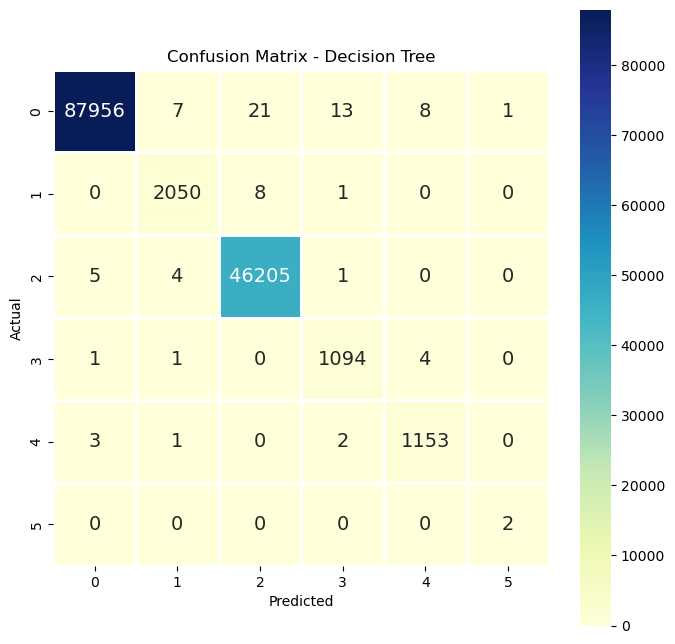

In [90]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

# Prediction
y_pred = dt.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("Decision Tree Performance:")
print(f"Accuracy:  {accuracy:.8f}")
print(f"Precision: {precision:.8f}")
print(f"Recall:    {recall:.8f}")
print(f"F1-score:  {f1:.8f}")

# Per Target Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=1,
    square=True,
    annot_kws={"fontsize": 14}
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()


Checking for Overfitting

In [91]:
scores = cross_val_score(dt, X_train, y_train, cv=3)
print(scores, scores.mean())


[0.99926924 0.99932091 0.99918067] 0.9992569409587923


In [92]:
print(dt.get_depth())
print(dt.get_n_leaves())

27
400


In [93]:
train_pred = dt.predict(X_train)
train_acc = (train_pred == y_train).mean()
print("Train accuracy:", train_acc)


Train accuracy: 0.9999261861879595


Random Forest

Random Forest Performance:
Accuracy:  0.99939368
Precision: 0.99939398
Recall:    0.99939368
F1-score:  0.99939370

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88006
           1       1.00      1.00      1.00      2059
           2       1.00      1.00      1.00     46215
           3       0.99      1.00      1.00      1100
           4       1.00      1.00      1.00      1159
           5       1.00      1.00      1.00         2

    accuracy                           1.00    138541
   macro avg       1.00      1.00      1.00    138541
weighted avg       1.00      1.00      1.00    138541



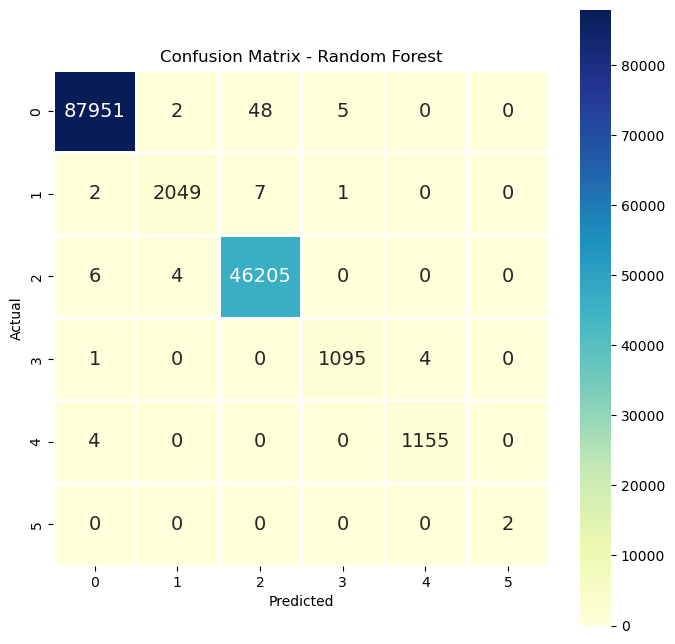

In [94]:
# Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("Random Forest Performance:")
print(f"Accuracy:  {accuracy:.8f}")
print(f"Precision: {precision:.8f}")
print(f"Recall:    {recall:.8f}")
print(f"F1-score:  {f1:.8f}")

# Per Target Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=1,
    square=True,
    annot_kws={"fontsize": 14}
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


XGBoost Performance:
Accuracy:  0.99839037
Precision: 0.99839332
Recall:    0.99839037
F1-score:  0.99838870

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     88006
           1       1.00      0.99      0.99      2059
           2       1.00      1.00      1.00     46215
           3       0.99      0.99      0.99      1100
           4       1.00      0.97      0.98      1159
           5       1.00      1.00      1.00         2

    accuracy                           1.00    138541
   macro avg       1.00      0.99      0.99    138541
weighted avg       1.00      1.00      1.00    138541



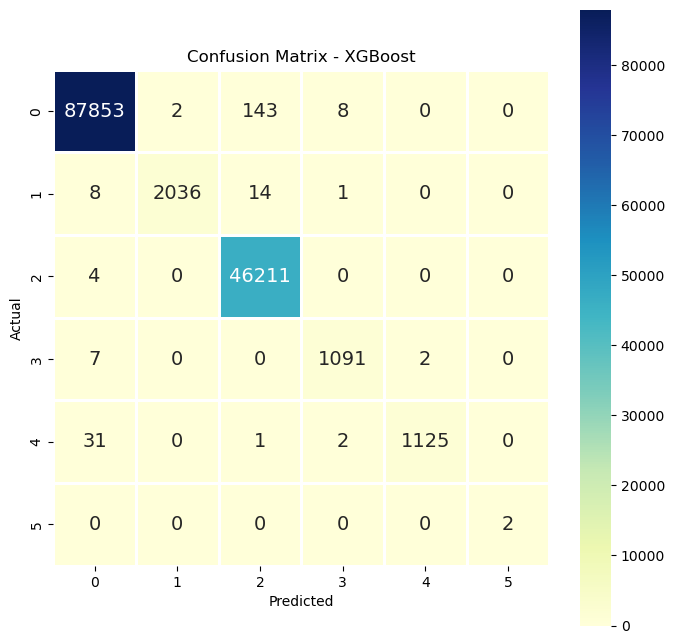

In [95]:
# XGBoost
xg = xgb.XGBClassifier(
    n_estimators=10,
    random_state=0,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xg.fit(X_train, y_train)

# Prediction
y_pred = xg.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average='weighted'
)

print("XGBoost Performance:")
print(f"Accuracy:  {accuracy:.8f}")
print(f"Precision: {precision:.8f}")
print(f"Recall:    {recall:.8f}")
print(f"F1-score:  {f1:.8f}")

# Per Target Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    linewidths=1,
    square=True,
    annot_kws={"fontsize": 14}
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()
